# Credit card fraud detection

- Final project for the course "Numerical Analysis for Machine Learning" by Prof. Edie Miglio
- A.Y. 2023-2024 - First semester
- Author: Francesco Buccoliero
- Politecnico di Milano | polimi.it

The most famous dataset (https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) contains transactions (492 frauds out of 284,807 transactions) made by credit cards in September 2013 by European cardholders.
Unfortunately, due to confidentiality issues, features have been anonymized and we cannot apply the same feature engineering as the paper authors did. I will then use a sinthetic dataset to perform feature engineering, trying to recreate, as much as possible, the research environment of the paper.

I followed the "Reproducible Machine Learning for Credit Card Fraud detection" handbook (https://fraud-detection-handbook.github.io/fraud-detection-handbook/) in order to generate a sinthetic dataset to perform feature engineering on. I changed some of the workflows proposed in order to recreate some of the features of the paper's model, wherever possible.

The sinthetic dataset involves the following features, among others:
- Geolocality of both customers and merchant (terminal)
- Time -> sequentiality
- Scenario-based fraudulent signaling
  - Compromised terminal
  - Compromised card

In particular since the scenarios only compromise terminals/cards for a limited amount of time this helps to incorporate real-life concept drift into our model.

The code for generating the dataset is available here: https://github.com/Fraud-Detection-Handbook/fraud-detection-handbook/blob/main/Chapter_3_GettingStarted/SimulatedDataset.ipynb
But I slightly modified it to get a more realistic result, also trying to incorporate in the dataset some of the notes from the paper, in particular:

- I expanded the concept of geographic proximity from a uniform-range and range-based generation (customers can only have transactions to terminals close to them) to a more real-life scenario:
  - The transaction is marked as "ECOM" with a probability that increases with the distance. If not "ECOM" a transaction is "F2F" (face-to-face). This helps to simulate the fact that customers usually do transactions in person to stores close to them, and prefer to pay online to stores that are far away.
- I improved all scenarios to add randomness in the number of cards/terminals compromised, in the days of compromission, in the general outcome of the fraud
- The ECOM transactions are 10x likely to be fraudulent in the "Compromised card" scenario than F2F transactions.

  

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
'''

!!!!!!!!!! WARNING !!!!!!!!!!
Executing this will re-load the transactions_df from files

'''


import os

def read_from_files(DIR_INPUT = "./simulated-data-raw/", BEGIN_DATE ="2024-01-01", END_DATE = "2024-03-30"):
    files = [os.path.join(DIR_INPUT, f) for f in os.listdir(DIR_INPUT) if f>=BEGIN_DATE+'.pkl' and f<=END_DATE+'.pkl']
    frames = []
    for f in files:
        df = pd.read_pickle(f)
        frames.append(df)
        del df
    df_final = pd.concat(frames)
    
    df_final=df_final.sort_values('TX_DATETIME')
    df_final.reset_index(drop=True,inplace=True)
    #  Note: -1 are missing values for real world data 
    df_final=df_final.replace([-1],0)
    return df_final

# uncomment this to load
# transactions_df = read_from_files()


In [4]:
############### Parameters ###############
# Only the main parameters that tune the dataset generation are  are here, the rest are in the functions

N_CUSTOMERS = 10000
N_TERMINALS = 1000
N_DAYS = 60

In [5]:
def generate_customer_profiles_table(n_customers):
  
  card_issuers = [
      {
          'name': 'VISA',
          'probability': 0.575,
          'max_mean_amount': 50
      },
      {
          'name': 'MASTERCARD',
          'probability': 0.375,
          'max_mean_amount': 75
      },
      {
          'name': 'AMEX',
          'probability': 0.02,
          'max_mean_amount': 150
      },
      {
          'name': 'JCB',
          'probability': 0.02,
          'max_mean_amount': 150
      },
      {
          'name': 'Discover',
          'probability': 0.01,
          'max_mean_amount': 100
      }
  ] # Distribution data is real (see below),max_mean_amount is arbitrary
      
  customer_id_properties=[]
  
  # Generate customer properties from random distributions 
  for customer_id in range(n_customers):
      
      x_customer_id = np.random.uniform(0,100)
      y_customer_id = np.random.uniform(0,100)
      
      card_issuer_idx = np.random.choice(list(range(len(card_issuers))), p = [x['probability'] for x in card_issuers]) # https://upgradedpoints.com/credit-cards/us-credit-card-market-share-by-network-issuer/
      card_issuer = card_issuers[card_issuer_idx]['name']
      card_type = np.random.choice(['CREDIT', 'DEBIT'], p = [0.416, 0.584]) # https://www.spglobal.com/marketintelligence/en/news-insights/research/debit-surpasses-credit-as-consumers-preferred-payment-card
      
      mean_amount = np.random.uniform(2,card_issuers[card_issuer_idx]['max_mean_amount']) # Arbitrary (but sensible) value
      std_amount = mean_amount/2 # Arbitrary (but sensible) value
      mean_nb_tx_per_day = np.random.uniform(0,5) # Arbitrary (but sensible) value 
      
      # Credit cards are used for larger transactions
      if card_type == 'CREDIT':
          mean_amount *= 1.5
          std_amount *= 1.5
          mean_nb_tx_per_day = int(mean_nb_tx_per_day*1.2)
      
      
      customer_id_properties.append([customer_id,
                                    x_customer_id, y_customer_id,
                                    mean_amount, std_amount,
                                    mean_nb_tx_per_day, card_issuer, card_type])
      
  customer_profiles_table = pd.DataFrame(customer_id_properties, columns=['CUSTOMER_ID',
                                                                    'x_customer_id', 'y_customer_id',
                                                                    'mean_amount', 'std_amount',
                                                                    'mean_nb_tx_per_day', 'card_issuer', 'card_type'])
  
  return customer_profiles_table

n_customers = 5
customer_profiles_table = generate_customer_profiles_table(n_customers)
customer_profiles_table

,CUSTOMER_ID,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day,card_issuer,card_type
0,0,75.298941,3.339765,16.530771,8.265386,3.000000,VISA,CREDIT
1,1,3.629013,25.542410,15.458285,7.729142,1.673458,VISA,DEBIT
2,2,50.423543,98.021578,46.815587,23.407793,1.686139,MASTERCARD,DEBIT
3,3,55.593774,18.025257,2.509023,1.254512,1.856918,MASTERCARD,DEBIT
4,4,64.897491,86.082996,4.205562,2.102781,3.000000,VISA,CREDIT


In [6]:
def generate_terminal_profiles_table(n_terminals):
  terminal_id_properties=[]
  
  MCCs = [
      {"name": "Agricultural services", "prob": 0.05, "prob_compromised": 1/100},
      {"name": "Contracted services", "prob": 0.08, "prob_compromised": 1/100},
      {"name": "Transportation", "prob": 0.10, "prob_compromised": 2/100},
      {"name": "Utilities", "prob": 0.07, "prob_compromised": 2/100},
      {"name": "Retail outlets", "prob": 0.12, "prob_compromised": 5/100},
      {"name": "Automobiles and vehicles", "prob": 0.05, "prob_compromised": 0.5/100},
      {"name": "Clothing outlets", "prob": 0.07, "prob_compromised": 5/100},
      {"name": "Miscellaneous outlets", "prob": 0.06, "prob_compromised": 5/100},
      {"name": "Service providers", "prob": 0.09, "prob_compromised": 5/100},
      {"name": "Business services", "prob": 0.08, "prob_compromised": 2/100},
      {"name": "Repair services", "prob": 0.06, "prob_compromised": 2/100},
      {"name": "Amusement and entertainment", "prob": 0.05, "prob_compromised": 2/100},
      {"name": "Professional services and membership organizations", "prob": 0.07, "prob_compromised": 1/100},
      {"name": "Government services", "prob": 0.05, "prob_compromised": 0.5/100}
  ]

  # Generate terminal properties from random distributions 
  for terminal_id in range(n_terminals):
      
      x_terminal_id = np.random.uniform(0,100)
      y_terminal_id = np.random.uniform(0,100)
      
      merchant_group_idx = np.random.choice(list(range(len(MCCs))), p = [x['prob'] for x in MCCs])
      merchant_group = MCCs[merchant_group_idx]['name']
      prob_compromised = MCCs[merchant_group_idx]['prob_compromised']
      
      terminal_id_properties.append([terminal_id,
                                    x_terminal_id, y_terminal_id, merchant_group, prob_compromised])
                                      
  terminal_profiles_table = pd.DataFrame(terminal_id_properties, columns=['TERMINAL_ID',
                                                                    'x_terminal_id', 'y_terminal_id', 'merchant_group', 'prob_compromised'])
  
  return terminal_profiles_table

n_terminals = 5
terminal_profiles_table = generate_terminal_profiles_table(n_terminals)
terminal_profiles_table

,TERMINAL_ID,x_terminal_id,y_terminal_id,merchant_group,prob_compromised
0,0,50.834304,10.661641,Retail outlets,0.05
1,1,53.596952,88.974059,Utilities,0.02
2,2,85.637548,51.578167,Agricultural services,0.01
3,3,54.184330,22.032959,Utilities,0.02
4,4,74.977379,3.406373,Clothing outlets,0.05


In [7]:
import random

def getDistanceAndProbECOM(customer_x, customer_y, terminal_x, terminal_y, smoothness = 0.1, travelLikelihood = 20):
  '''
  smoothness: flexibility of the sigmoid function
  travelLikelihood: Equals to the distance where p(ECOM) = p(F2F) = 0.5
    - lower = a distant transaction is less likely to be F2F
    - higher = a distant transaction is more likely to be F2F
  '''
  assert(smoothness > 0)
  assert(travelLikelihood > 0)
  distance = np.abs(np.sqrt((customer_x - terminal_x)**2 + (customer_y - terminal_y)**2))
  return distance, 1/(1 + np.exp(smoothness*(travelLikelihood - distance)))

def generate_transactions_table(customer_profile, available_terminals, start_date = "2024-01-01", nb_days = 365):
  customer_transactions = []
  tx_count = 0
  # For all days
  for day in range(nb_days):
      
      # Random number of transactions for that day 
      nb_tx = np.random.poisson(customer_profile.mean_nb_tx_per_day)
      
      # If nb_tx positive, let us generate transactions
      if nb_tx>0:
          
          for _ in range(nb_tx):
              
              # Time of transaction: Around noon, std 20000 seconds. This choice aims at simulating the fact that 
              # most transactions occur during the day.
              time_tx = int(np.random.normal(86400/2, 20000))
              
              # If transaction time between 0 and 86400, let us keep it, otherwise, let us discard it
              if (time_tx>0) and (time_tx<86400):
                  
                  # Amount is drawn from a abs(normal distribution)
                  amount = np.abs(np.random.normal(customer_profile.mean_amount, customer_profile.std_amount)) 
                  amount = np.round(amount,decimals=2)
                  
                  if len(available_terminals)>0:
                      terminal = available_terminals.sample(1).iloc[0]
                      terminal_id = terminal.TERMINAL_ID
                      distance, probEcom = getDistanceAndProbECOM(customer_profile.x_customer_id, customer_profile.y_customer_id, terminal.x_terminal_id, terminal.y_terminal_id)
                      transactionType = np.random.choice(['F2F', 'ECOM'], p=[1-probEcom, probEcom])
                      customer_transactions.append([tx_count, time_tx+day*86400, day,
                                                      customer_profile.CUSTOMER_ID, 
                                                      terminal_id, distance, transactionType, amount, customer_profile.card_issuer, customer_profile.card_type, terminal.merchant_group])
                      tx_count += 1
  customer_transactions = pd.DataFrame(customer_transactions, columns=['CUST_TX_ID', 'TX_TIME_SECONDS', 'TX_TIME_DAYS', 'CUSTOMER_ID', 'TERMINAL_ID', 'TX_DISTANCE', 'TX_TYPE', 'TX_AMOUNT', "CUSTOMER_CARD_ISSUER", "CUSTOMER_CARD_TYPE", 'TERMINAL_MCC'])

  if len(customer_transactions)>0:
      customer_transactions['TX_DATETIME'] = pd.to_datetime(customer_transactions["TX_TIME_SECONDS"], unit='s', origin=start_date)
      customer_transactions=customer_transactions[['CUST_TX_ID','TX_DATETIME','CUSTOMER_ID', 'TERMINAL_ID', 'TX_DISTANCE', 'TX_AMOUNT', 'TX_TYPE', 'TX_TIME_SECONDS', 'TX_TIME_DAYS', "CUSTOMER_CARD_ISSUER", "CUSTOMER_CARD_TYPE", "TERMINAL_MCC"]]

  return customer_transactions  
    
transaction_table_customer_0=generate_transactions_table(customer_profiles_table.iloc[0],
                                                         terminal_profiles_table, 
                                                         start_date = "2024-01-01", 
                                                         nb_days = 5)
transaction_table_customer_0

,CUST_TX_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_DISTANCE,TX_AMOUNT,TX_TYPE,TX_TIME_SECONDS,TX_TIME_DAYS,CUSTOMER_CARD_ISSUER,CUSTOMER_CARD_TYPE,TERMINAL_MCC
0,0,2024-01-01 03:16:12,0,0,25.536804,15.80,F2F,11772,0,VISA,CREDIT,Retail outlets
1,1,2024-01-01 23:25:54,0,0,25.536804,15.37,F2F,84354,0,VISA,CREDIT,Retail outlets
2,2,2024-01-02 05:49:59,0,4,0.328388,13.85,F2F,107399,1,VISA,CREDIT,Clothing outlets
3,3,2024-01-02 16:03:52,0,1,88.341432,12.32,ECOM,144232,1,VISA,CREDIT,Utilities
4,4,2024-01-02 09:50:47,0,3,28.200395,18.27,ECOM,121847,1,VISA,CREDIT,Utilities
5,5,2024-01-02 11:09:10,0,3,28.200395,30.68,ECOM,126550,1,VISA,CREDIT,Utilities
6,6,2024-01-02 03:50:41,0,3,28.200395,13.19,F2F,100241,1,VISA,CREDIT,Utilities
7,7,2024-01-03 19:21:41,0,1,88.341432,7.78,ECOM,242501,2,VISA,CREDIT,Utilities
8,8,2024-01-04 19:56:10,0,2,49.333865,16.81,ECOM,330970,3,VISA,CREDIT,Agricultural services
9,9,2024-01-04 04:39:08,0,3,28.200395,19.23,F2F,275948,3,VISA,CREDIT,Utilities


In [8]:
# The general function to generate the transactions for all customers

import time

def generate_dataset(n_customers, n_terminals, nb_days, parallelize=True):
    
    if parallelize:
      # Parallelizing pandas apply operation
      from pandarallel import pandarallel
      pandarallel.initialize(progress_bar=False)
    
    start_time=time.time()
    customer_profiles_table = generate_customer_profiles_table(n_customers)
    print("Time to generate customer profiles table: {0:.2}s".format(time.time()-start_time))
    
    start_time=time.time()
    terminal_profiles_table = generate_terminal_profiles_table(n_terminals)
    print("Time to generate terminal profiles table: {0:.2}s".format(time.time()-start_time))
    
    start_time=time.time()
    if parallelize:
      transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').parallel_apply(lambda x : generate_transactions_table(x.iloc[0], terminal_profiles_table, nb_days=nb_days)).reset_index(drop=True)
    else:
      transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').apply(lambda x : generate_transactions_table(x.iloc[0], terminal_profiles_table, nb_days=nb_days)).reset_index(drop=True)
    print("Time to generate transactions: {0:.2}s".format(time.time()-start_time))
    
    # Sort transactions chronologically
    transactions_df=transactions_df.sort_values('TX_DATETIME')
    transactions_df.reset_index(drop=True,inplace=True)
    
    return (customer_profiles_table, terminal_profiles_table, transactions_df)

In [9]:
(customer_profiles_table, terminal_profiles_table, transactions_df)=generate_dataset(n_customers=N_CUSTOMERS, n_terminals=N_TERMINALS, nb_days=N_DAYS)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Time to generate customer profiles table: 0.67s
Time to generate terminal profiles table: 0.038s
Time to generate transactions: 2e+02s


In [10]:
transactions_df.describe()

,TX_DATETIME,TX_DISTANCE,TX_AMOUNT
count,1466466,1.466466e+06,1.466466e+06
mean,2024-01-30 23:58:48.444559360,5.256780e+01,3.993205e+01
min,2024-01-01 00:00:28,4.399385e-02,0.000000e+00
25%,2024-01-16 00:24:53,3.309924e+01,1.366000e+01
50%,2024-01-31 00:14:18,5.178335e+01,3.024000e+01
75%,2024-02-14 22:08:54.750000128,7.112254e+01,5.503000e+01
max,2024-02-29 23:59:47,1.394327e+02,5.948000e+02
std,NaN,2.494926e+01,3.690105e+01


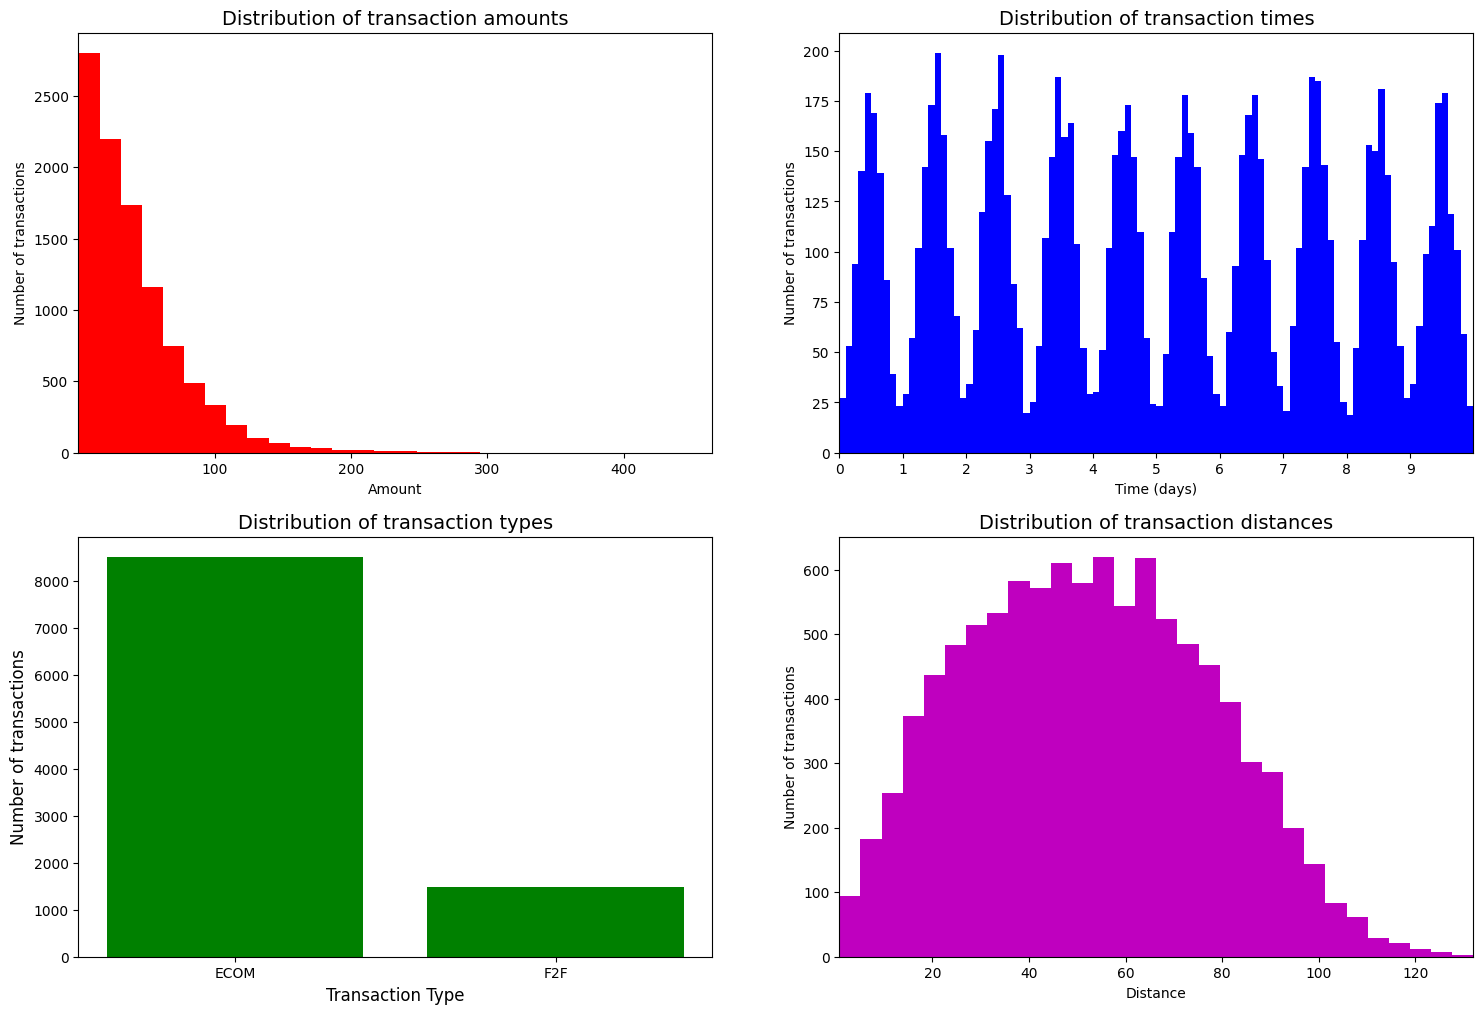

In [11]:
distribution_amount_times_fig, ax = plt.subplots(2, 2, figsize=(18,12))

amount_val = transactions_df[transactions_df.TX_TIME_DAYS<10]['TX_AMOUNT'].sample(n=10000).values
time_val = transactions_df[transactions_df.TX_TIME_DAYS<10]['TX_TIME_SECONDS'].sample(n=10000).values
type_counts = transactions_df[transactions_df.TX_TIME_DAYS<10]['TX_TYPE'].sample(n=10000).value_counts()
distance_val = transactions_df[transactions_df.TX_TIME_DAYS<10]['TX_DISTANCE'].sample(n=10000).values

# Distribution of transaction amounts
ax[0][0].hist(amount_val, color='r', bins=30)
ax[0][0].set_title('Distribution of transaction amounts', fontsize=14)
ax[0][0].set_xlim([min(amount_val), max(amount_val)])
ax[0][0].set(xlabel="Amount", ylabel="Number of transactions")

# Distribution of transaction times
ax[0][1].hist(time_val/86400, color='b', bins=100)
ax[0][1].set_title('Distribution of transaction times', fontsize=14)
ax[0][1].set_xlim([min(time_val/86400), max(time_val/86400)])
ax[0][1].set_xticks(range(10))
ax[0][1].set(xlabel="Time (days)", ylabel="Number of transactions")

# Distribution of transaction types
ax[1][0].bar(type_counts.index, type_counts.values, color='g')
ax[1][0].set_title('Distribution of transaction types', fontsize=14)
ax[1][0].set_xlabel("Transaction Type", fontsize=12)
ax[1][0].set_ylabel("Number of transactions", fontsize=12)

# Distribution of transaction distances
ax[1][1].hist(distance_val, color='m', bins=30)
ax[1][1].set_title('Distribution of transaction distances', fontsize=14)
ax[1][1].set_xlim([min(distance_val), max(distance_val)])
ax[1][1].set(xlabel="Distance", ylabel="Number of transactions")

plt.show()


In [12]:
def add_frauds(customer_profiles_table, terminal_profiles_table, transactions_df, \
  maxPercentageCompromisedTerminals = 2, maxPercentageCompromisedCustomersF2F = 0.1, terminal_day_compromised_prob = 0.5, customer_day_compromised_prob = 0.2):
    
    # By default, all transactions are genuine
    transactions_df['TX_FRAUD']=0
    transactions_df['TX_FRAUD_SCENARIO']=0
    
    ''' Not considering scenario 1 as discussed above
    # Scenario 1
    transactions_df.loc[transactions_df.TX_AMOUNT>220, 'TX_FRAUD']=1
    transactions_df.loc[transactions_df.TX_AMOUNT>220, 'TX_FRAUD_SCENARIO']=1
    '''
    nb_frauds_scenario_1=transactions_df.TX_FRAUD.sum()
    print("Number of frauds from scenario 1: "+str(nb_frauds_scenario_1))
    
    # Scenario 2: Phishing/Terminal compromise
    # Every day, a percentage X% of all terminals is potentially compromised. 
    # All transactions on these terminals in the next Y days will be marked as fraudulent. 
    for day in range(transactions_df.TX_TIME_DAYS.max()):
      if np.random.uniform(0,1) < terminal_day_compromised_prob:
        potentially_compromised_terminals_number = int(maxPercentageCompromisedTerminals*len(terminal_profiles_table)/100)
        potentially_compromised_terminals = terminal_profiles_table.sample(n=potentially_compromised_terminals_number)
        
        compromised_terminals = []
        
        for pct in potentially_compromised_terminals.iterrows():
            if np.random.uniform(0,1) < pct[1].prob_compromised:
                compromised_terminals.append(pct[1].TERMINAL_ID)
        
        compromised_transactions=transactions_df[(transactions_df.TX_TIME_DAYS>=day) & 
                                                    (transactions_df.TX_TIME_DAYS<day+np.random.uniform(1,10)) & 
                                                    (transactions_df.TERMINAL_ID.isin(compromised_terminals))]
                            
        transactions_df.loc[compromised_transactions.index,'TX_FRAUD']=1
        transactions_df.loc[compromised_transactions.index,'TX_FRAUD_SCENARIO']=2
    
    nb_frauds_scenario_2=transactions_df.TX_FRAUD.sum() - nb_frauds_scenario_1
    print("Number of frauds from scenario 2: "+str(nb_frauds_scenario_2))
    
    # Scenario 3: Stolen card
    # Every day, a list of N customers is drawn at random. 
    # In the next 14 days, x% of their transactions have their amounts multiplied 
    # by Y and marked as fraudulent. The chance is 10x% for ECOM transactions.
    
    for day in range(transactions_df.TX_TIME_DAYS.max()):
        if np.random.uniform(0,1) < customer_day_compromised_prob:
          compromised_customers_number = int(maxPercentageCompromisedCustomersF2F*len(customer_profiles_table)/100)
          compromised_customers = customer_profiles_table.CUSTOMER_ID.sample(n=compromised_customers_number).values
          
          compromised_transactions=transactions_df[(transactions_df.TX_TIME_DAYS>=day) & 
                                                      (transactions_df.TX_TIME_DAYS<day+np.random.uniform(2,21)) & 
                                                      (transactions_df.CUSTOMER_ID.isin(compromised_customers))]
          
          compromised_transactions_ECOM = compromised_transactions[compromised_transactions.TX_TYPE=='ECOM']
          compromised_transactions_F2F = compromised_transactions[compromised_transactions.TX_TYPE=='F2F']
          
          nb_compromised_transactions_ECOM=len(compromised_transactions_ECOM)
          nb_compromised_transactions_F2F=len(compromised_transactions_F2F)
          
          index_frauds_ECOM = random.sample(list(compromised_transactions_ECOM.index.values),k=int(nb_compromised_transactions_ECOM *  maxPercentageCompromisedCustomersF2F * 10))
          index_frauds_F2F = random.sample(list(compromised_transactions_F2F.index.values),k=int(nb_compromised_transactions_F2F * maxPercentageCompromisedCustomersF2F))
          
          transactions_df.loc[index_frauds_ECOM,'TX_AMOUNT']=transactions_df.loc[index_frauds_ECOM,'TX_AMOUNT']*np.random.uniform(1,5)
          transactions_df.loc[index_frauds_ECOM,'TX_FRAUD']=1
          transactions_df.loc[index_frauds_ECOM,'TX_FRAUD_SCENARIO']=3
          
          transactions_df.loc[index_frauds_F2F,'TX_AMOUNT']=transactions_df.loc[index_frauds_F2F,'TX_AMOUNT']*np.random.uniform(1,5)
          transactions_df.loc[index_frauds_F2F,'TX_FRAUD']=1
          transactions_df.loc[index_frauds_F2F,'TX_FRAUD_SCENARIO']=3
                             
    nb_frauds_scenario_3=transactions_df.TX_FRAUD.sum()-nb_frauds_scenario_2-nb_frauds_scenario_1
    print("Number of frauds from scenario 3: "+str(nb_frauds_scenario_3))
    
    return transactions_df   

In [13]:
%time transactions_df = add_frauds(customer_profiles_table, terminal_profiles_table, transactions_df)

Number of frauds from scenario 1: 0
Number of frauds from scenario 2: 1472
Number of frauds from scenario 3: 3812
CPU times: user 7.88 s, sys: 54.8 ms, total: 7.94 s
Wall time: 8.02 s


In [14]:
print("Percentage of frauds: {:.2f}%".format(100*transactions_df.TX_FRAUD.mean()))

Percentage of frauds: 0.36%


In [15]:
import os
import datetime

def saveFiles():
  DIR_OUTPUT = "./simulated-data-raw/"

  if not os.path.exists(DIR_OUTPUT):
      os.makedirs(DIR_OUTPUT)

  start_date = datetime.datetime.strptime("2024-01-01", "%Y-%m-%d")

  for day in range(transactions_df.TX_TIME_DAYS.max()+1):
      
      transactions_day = transactions_df[transactions_df.TX_TIME_DAYS==day].sort_values('TX_TIME_SECONDS')
      
      date = start_date + datetime.timedelta(days=day)
      filename_output = date.strftime("%Y-%m-%d")+'.pkl'
      transactions_day.to_pickle(DIR_OUTPUT+filename_output)
      
      
# uncomment to save
saveFiles()

In [16]:
transactions_df.describe()

,TX_DATETIME,TX_DISTANCE,TX_AMOUNT,TX_FRAUD,TX_FRAUD_SCENARIO
count,1466466,1.466466e+06,1.466466e+06,1.466466e+06,1.466466e+06
mean,2024-01-30 23:58:48.444559360,5.256780e+01,4.008011e+01,3.603220e-03,9.808615e-03
min,2024-01-01 00:00:28,4.399385e-02,0.000000e+00,0.000000e+00,0.000000e+00
25%,2024-01-16 00:24:53,3.309924e+01,1.368000e+01,0.000000e+00,0.000000e+00
50%,2024-01-31 00:14:18,5.178335e+01,3.028000e+01,0.000000e+00,0.000000e+00
75%,2024-02-14 22:08:54.750000128,7.112254e+01,5.514000e+01,0.000000e+00,0.000000e+00
max,2024-02-29 23:59:47,1.394327e+02,8.479807e+02,1.000000e+00,3.000000e+00
std,NaN,2.494926e+01,3.730455e+01,5.991861e-02,1.653105e-01


We will now perform a RF vs LSTM comparison with two datasets:
- The BASE dataset, including only essential information, no sequentiality and no time feature engineering
- The FULL dataset, including all the informations

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from category_encoders import BinaryEncoder

def preprocessing(dataframe, LSTM_time_step=0, full_dataset=True):
  
  # dropping ids and other not-useful columns
  X = dataframe.drop(['TX_FRAUD_SCENARIO', 'TX_DISTANCE'], axis=1)
  X['TX_DATETIME'] = (X['TX_DATETIME'] - X['TX_DATETIME'].min()).dt.total_seconds()

  y = dataframe['TX_FRAUD']
  if LSTM_time_step > 0:
    # save for LSTM sequences processing
    customer_id = X['CUSTOMER_ID']
    cust_tx_id = X['CUST_TX_ID']
    cust_fraud = y

  # Preprocessing
  if full_dataset:
    numerical_cols = ['TX_DATETIME', 'TX_AMOUNT', 'TX_TIME_SECONDS', 'TX_TIME_DAYS']
    categorical_cols = ['CUST_TX_ID','CUSTOMER_ID', 'TERMINAL_ID', 'TX_TYPE', 'CUSTOMER_CARD_ISSUER', 'CUSTOMER_CARD_TYPE', 'TERMINAL_MCC']
    if LSTM_time_step == 0:
      # dropping CUST_TX_ID as it's only used for building the sequences in LSTM, not a feature
      categorical_cols.remove('CUST_TX_ID')
  else:
    numerical_cols = ['TX_DATETIME', 'TX_AMOUNT']
    categorical_cols = ['TX_TYPE']
  
  # Step Normalize numerical and one-hot encode categorical columns
  preprocessor = ColumnTransformer(
      transformers=[
          ('num', StandardScaler(), numerical_cols),
          ('cat', BinaryEncoder(), categorical_cols)
      ],
      remainder='drop'
  )
  
  X_scaled = preprocessor.fit_transform(X)
  
  ## LSTM
  
  # Add back columns if LSTM_time_step > 0
  if LSTM_time_step > 0:
    # Get the feature names for the numerical columns - they remain unchanged
    numerical_features = numerical_cols

    # For binary encoded columns, get the new feature names
    # BinaryEncoder from category_encoders doesn't directly give the new feature names
    # so we manually fit and then use get_feature_names
    binary_encoder = BinaryEncoder(cols=categorical_cols)
    binary_encoder.fit(X[categorical_cols])
    categorical_features = binary_encoder.get_feature_names_out()

    # Combine all feature names
    all_features = list(numerical_features) + list(categorical_features)

    # Convert the NumPy array back to a pandas DataFrame
    X_scaled_df = pd.DataFrame(X_scaled, columns=all_features)
    X_scaled_df['CUSTOMER_ID'] = customer_id
    X_scaled_df['CUST_TX_ID'] = cust_tx_id
    X_scaled_df['TX_FRAUD'] = cust_fraud
    
    sequences = []
    labels = []
    
    for _, group in X_scaled_df.groupby('CUSTOMER_ID'):
      customer_data = group.sort_values(by='CUST_TX_ID')
      
      # Drop CUSTOMER_ID column as it's no longer needed in the sequences
      labels_array = customer_data['TX_FRAUD'].to_numpy()
      customer_data = customer_data.drop(columns=['CUSTOMER_ID', 'TX_FRAUD', 'CUST_TX_ID'])
      customer_data_array = customer_data.to_numpy()
      
      if len(customer_data_array) >= LSTM_time_step:
        # Create sequences with a fixed length of 5 (time_step) and step size of 1
        for i in range(len(customer_data_array) - LSTM_time_step + 1):
          sequences.append(customer_data_array[i:i+LSTM_time_step])
          # The label for a sequence is 1 if all labels in the sequence are 1, otherwise 0
          labels.append(int(all(labels_array[i:i+LSTM_time_step])))

    # Convert sequences and labels into numpy arrays
    X_scaled = np.array(sequences)
    y = np.array(labels)
  return X_scaled, y
    

In [22]:
#### RANDOM FOREST ####
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score, average_precision_score
from sklearn.ensemble import RandomForestClassifier

def _RF(full_dataset=True):
  X_rf , y = preprocessing(transactions_df,0, full_dataset=full_dataset)

  # Oversampling
  smote = SMOTE(sampling_strategy='auto')
  X_rf, y = smote.fit_resample(X_rf, y)

  X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y, test_size=0.2)

  # Initialize and train the Random Forest classifier
  rf_classifier = RandomForestClassifier(n_estimators=5)
  rf_classifier.fit(X_train_rf, y_train_rf)

  # Making predictions on the test set
  y_pred_rf = rf_classifier.predict(X_test_rf)

  # Printing the classification report and accuracy
  print(classification_report(y_test_rf, y_pred_rf))
  print("Accuracy:", accuracy_score(y_test_rf, y_pred_rf))

  # Calculating the Average Precision Score (AUCPR)
  y_pred_prob_rf = rf_classifier.predict_proba(X_test_rf)[:, 1]  # Get probabilities for the positive class
  rf_aucpr = average_precision_score(y_test_rf, y_pred_prob_rf)
  print(f"Random Forest AUCPR: {rf_aucpr}")

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


def _LSTM(time_steps=5, full_dataset=True):
  X_lstm, y = preprocessing(transactions_df,time_steps, full_dataset=full_dataset)
  
  # Reshape X_lstm to 2D array
  n_samples, n_time_steps, n_features = X_lstm.shape
  X_lstm_2d = X_lstm.reshape(n_samples, -1)
  
  # Oversampling
  smote = SMOTE(sampling_strategy='auto')
  X_lstm_resampled_2d, y_resampled = smote.fit_resample(X_lstm_2d, y)
  
  # Reshape X_lstm back to 3D array
  X_lstm_resampled = X_lstm_resampled_2d.reshape(-1, n_time_steps, n_features)

  # Split the dataset
  X_train, X_test, y_train, y_test = train_test_split(X_lstm_resampled, y_resampled, test_size=0.3, random_state=42)
  
  # To prevent ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).
  X_train = np.asarray(X_train).astype(np.float32)
  y_train = np.asarray(y_train).astype(np.float32)
  X_test = np.asarray(X_test).astype(np.float32)
  y_test = np.asarray(y_test).astype(np.float32)
  
  model = Sequential([
      LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])), # First LSTM layer
      Dropout(0.2), # Applying dropout to LSTM nodes
      LSTM(50), # Second LSTM layer
      Dropout(0.2), # Applying dropout to LSTM nodes
      Dense(5, activation='tanh'), # Single hidden layer
      Dense(1, activation='sigmoid') # Output layer for logistic regression classifier
  ])

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  model.fit(X_train, y_train, epochs=2, batch_size=32, validation_split=0.1, verbose=1)

  y_pred_prob_lstm = model.predict(X_test).ravel() 
  y_pred_lstm = (y_pred_prob_lstm > 0.5).astype(int)

  # Printing the classification report and accuracy for the LSTM predictions
  print(classification_report(y_test, y_pred_lstm))
  print("Accuracy:", accuracy_score(y_test, y_pred_lstm))

  # Calculating the Average Precision Score (AUCPR) for the LSTM
  lstm_aucpr = average_precision_score(y_test, y_pred_prob_lstm)
  print(f"LSTM AUCPR: {lstm_aucpr}")

In [24]:
# Random forest BASE dataset
_RF(False)

              precision    recall  f1-score   support

           0       0.93      0.87      0.90    291196
           1       0.88      0.93      0.90    290418

    accuracy                           0.90    581614
   macro avg       0.90      0.90      0.90    581614
weighted avg       0.90      0.90      0.90    581614

Accuracy: 0.8986269243862768
Random Forest AUCPR: 0.9171772000594829


In [25]:
# Random forest FULL dataset
_RF()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    291358
           1       1.00      1.00      1.00    290256

    accuracy                           1.00    581614
   macro avg       1.00      1.00      1.00    581614
weighted avg       1.00      1.00      1.00    581614

Accuracy: 0.9994738778640129
Random Forest AUCPR: 0.9998830433664151


In [26]:
# LSTM BASE dataset
_LSTM(5, False)

Epoch 1/2
55938/55938 [==============================] - 290s 5ms/step - loss: 0.1711 - accuracy: 0.9345 - val_loss: 0.0814 - val_accuracy: 0.9729
Epoch 2/2
26637/26637 [==============================] - 41s 2ms/step
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98    425882
         1.0       0.97      1.00      0.98    426497

    accuracy                           0.98    852379
   macro avg       0.99      0.98      0.98    852379
weighted avg       0.99      0.98      0.98    852379

Accuracy: 0.9845808026711123
LSTM AUCPR: 0.9961508058842701


In [27]:
# LSTM FULL dataset
_LSTM(5)

Epoch 1/2
55938/55938 [==============================] - 268s 5ms/step - loss: 0.0083 - accuracy: 0.9973 - val_loss: 6.1702e-04 - val_accuracy: 0.9999
Epoch 2/2
26637/26637 [==============================] - 53s 2ms/step
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    425882
         1.0       1.00      1.00      1.00    426497

    accuracy                           1.00    852379
   macro avg       1.00      1.00      1.00    852379
weighted avg       1.00      1.00      1.00    852379

Accuracy: 0.999882681295527
LSTM AUCPR: 0.9999979465286308
